In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import math as math
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn import preprocessing
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import pinv_extended

In [190]:
pd.set_option('display.max_columns', None)
#/home2/rke27/crossover_datasets/
#reading in recomb rate intervals with features from ARG-inference
df = pd.read_csv('/home2/rke27/crossover_datasets/Maize_Teosinte_ARGinferred_v4_chrscombined_1Mb_noscinot_phased_CG_CHG_tCG_tCHG_Mnase_H2az_H3K27me3_gene_H3K4me3_GCcontent2_H3K4me1_H3K9ac_H3K36me3_cent_bothtels.bed', sep='\t', header = None)
df.columns = ["chrom", "start", "end", "rate_maize", 'rate_teo', "maizeCG%", "maizeCHG%", "teoCG%", "teoCHG%","Mnase", "H2AZ", "H3K27me3", "gene_density", "H3K4me3", "GC_content", "H3K4me1","H3K9ac","H3K36me3", "dist_cent", "dist_tel"]
display(df)

,chrom,start,end,rate_maize,rate_teo,maizeCG%,maizeCHG%,teoCG%,teoCHG%,Mnase,H2AZ,H3K27me3,gene_density,H3K4me3,GC_content,H3K4me1,H3K9ac,H3K36me3,dist_cent,dist_tel
0,1,2000000,3000000,1.996044e-08,2.960638e-08,78.635760,57.561262,0.773747,0.623448,29412,17493,44836,317,57919,0.468554,56825,21847,74671,140318767,2000000
1,1,3000000,4000000,2.789612e-08,2.858826e-08,74.404379,55.029587,0.661707,0.528817,27999,24821,44219,245,62768,0.458187,58421,22993,73343,139318767,3000000
2,1,4000000,5000000,3.035614e-08,2.609778e-08,75.043757,56.274724,0.708080,0.578034,28931,24969,103107,292,50983,0.487450,64434,21727,88217,138318767,4000000
3,1,5000000,6000000,3.284584e-08,4.694864e-08,72.754892,56.782663,0.650217,0.534069,27284,27155,62582,134,51145,0.483084,48389,25299,54899,137318767,5000000
4,1,6000000,7000000,2.155726e-08,3.898457e-08,77.859629,60.243039,0.711155,0.604436,29796,21676,58379,168,40968,0.462503,63084,22213,71414,136318767,6000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1844,9,154000000,155000000,6.124275e-08,4.903103e-08,65.281450,49.307084,0.573142,0.452663,31541,38025,65138,271,89206,0.466802,57967,27938,65658,12681233,152041717
1845,9,155000000,156000000,5.899818e-08,8.634532e-08,71.439687,51.464578,0.643501,0.495842,23750,26605,30088,293,72188,0.459216,64296,21950,75941,13681233,151041717
1846,9,156000000,157000000,6.566217e-08,7.436023e-08,69.755361,52.629610,0.647853,0.513491,28543,36282,61471,297,65546,0.486226,54241,23674,72507,14681233,150041717
1847,9,157000000,158000000,6.319929e-08,8.047101e-08,74.880650,53.407667,0.690873,0.546387,28998,23778,21640,451,70873,0.470173,77528,24878,96960,15681233,149041717


In [191]:
#changing these features to be float instead of an object
s = df.select_dtypes(include='object').columns
df[s] = df[s].astype("float")
#so recombination rate is whole numbers
df['rate_maize']=df['rate_maize']*1e8
df['rate_teo']=df['rate_teo']*1e8

In [192]:
#dealing with missing data, usually replace as NaN so Python recognizes it
df.replace('NAN','NaN', regex = True, inplace = True)

In [193]:
df["teoCG%"] = df["teoCG%"]*100
df["teoCHG%"] = df["teoCHG%"]*100

In [194]:
#breaking up chromosomes into each file
df_chr1 = df[df['chrom'] == 1]
#df_chr2 = df[df['chrom'] == 2]
df_chr3 = df[df['chrom'] == 3]
df_chr4 = df[df['chrom'] == 4]
df_chr5 = df[df['chrom'] == 5]
df_chr6 = df[df['chrom'] == 6]
df_chr7 = df[df['chrom'] == 7]
df_chr8 = df[df['chrom'] == 8]
df_chr9 = df[df['chrom'] == 9]
df_chr10 = df[df['chrom'] == 10]

In [195]:
#scaling the telomere data to be centered & have a sd of 1
from sklearn.preprocessing import StandardScaler

scaler = MinMaxScaler()

# Fit and transform only the 'target_column'
df_chr1["dist_tel"] = scaler.fit_transform(df_chr1[["dist_tel"]])
#df_chr2["dist_tel"] = scaler.fit_transform(df_chr2[["dist_tel"]])
df_chr3["dist_tel"] = scaler.fit_transform(df_chr3[["dist_tel"]])
df_chr4["dist_tel"] = scaler.fit_transform(df_chr4[["dist_tel"]])
df_chr5["dist_tel"] = scaler.fit_transform(df_chr5[["dist_tel"]])
df_chr6["dist_tel"] = scaler.fit_transform(df_chr6[["dist_tel"]])
df_chr7["dist_tel"] = scaler.fit_transform(df_chr7[["dist_tel"]])
df_chr8["dist_tel"] = scaler.fit_transform(df_chr8[["dist_tel"]])
df_chr9["dist_tel"] = scaler.fit_transform(df_chr9[["dist_tel"]])
df_chr10["dist_tel"] = scaler.fit_transform(df_chr10[["dist_tel"]])

/tmp/ipykernel_1487546/3556872681.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chr1["dist_tel"] = scaler.fit_transform(df_chr1[["dist_tel"]])
/tmp/ipykernel_1487546/3556872681.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chr3["dist_tel"] = scaler.fit_transform(df_chr3[["dist_tel"]])
/tmp/ipykernel_1487546/3556872681.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [196]:
#scaling the centromere data to be centered & have a sd of 1
from sklearn.preprocessing import StandardScaler

scaler = MinMaxScaler()

# Fit and transform only the 'target_column'
df_chr1["dist_cent"] = scaler.fit_transform(df_chr1[["dist_cent"]])
#df_chr2["dist_cent"] = scaler.fit_transform(df_chr2[["dist_cent"]])
df_chr3["dist_cent"] = scaler.fit_transform(df_chr3[["dist_cent"]])
df_chr4["dist_cent"] = scaler.fit_transform(df_chr4[["dist_cent"]])
df_chr5["dist_cent"] = scaler.fit_transform(df_chr5[["dist_cent"]])
df_chr6["dist_cent"] = scaler.fit_transform(df_chr6[["dist_cent"]])
df_chr7["dist_cent"] = scaler.fit_transform(df_chr7[["dist_cent"]])
df_chr8["dist_cent"] = scaler.fit_transform(df_chr8[["dist_cent"]])
df_chr9["dist_cent"] = scaler.fit_transform(df_chr9[["dist_cent"]])
df_chr10["dist_cent"] = scaler.fit_transform(df_chr10[["dist_cent"]])

/tmp/ipykernel_1487546/1860251060.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chr1["dist_cent"] = scaler.fit_transform(df_chr1[["dist_cent"]])
/tmp/ipykernel_1487546/1860251060.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chr3["dist_cent"] = scaler.fit_transform(df_chr3[["dist_cent"]])
/tmp/ipykernel_1487546/1860251060.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [197]:
#Split the data differently, instead of training on chr. 1-8 & testing on chr. 9-10, we can just subset the data in the original dataframe that contained all chromosomes
df = pd.concat([df_chr1,df_chr3,df_chr4,df_chr5,df_chr6,df_chr7,df_chr8,df_chr9,df_chr10])

# Replacing infinite with nan 
df.replace([np.inf, -np.inf], np.nan, inplace=True) 

#centering all predictors by subtracting the mean to reduce overfitting
df['rate_maize'] = df['rate_maize']**0.5
df['rate_teo'] = df['rate_teo']**0.5
df['rate_maize'] = df['rate_maize'] - df['rate_maize'].mean()
df['rate_teo'] = df['rate_teo'] - df['rate_teo'].mean()
df['maizeCG%'] = df['maizeCG%'] - df['maizeCG%'].mean()
df['maizeCHG%'] = df['maizeCHG%'] - df['maizeCHG%'].mean()
df['teoCHG%'] = df['teoCHG%'] - df['teoCHG%'].mean()
df['teoCG%'] = df['teoCG%'] - df['teoCG%'].mean()
df['Mnase'] = df['Mnase'] - df['Mnase'].mean()
df['H2AZ'] = df['H2AZ'] - df['H2AZ'].mean()
df['H3K4me3'] = df['H3K4me3'] - df['H3K4me3'].mean()
df['H3K4me1'] = df['H3K4me1'] - df['H3K4me1'].mean()
df['H3K27me3'] = df['H3K27me3'] - df['H3K27me3'].mean()
df['dist_cent'] = df['dist_cent'] - df['dist_cent'].mean()
df['dist_tel'] = df['dist_tel'] - df['dist_tel'].mean()
df['GC_content'] = df['GC_content'] - df['GC_content'].mean()
df['gene_density'] = df['gene_density'] - df['gene_density'].mean()

#adding in interaction terms
df['distchrom'] = df['dist_cent'] * df['chrom']
df['maizeCGCHGint'] = df['maizeCG%'] * df['maizeCHG%']
df['maizeCGcentint'] = df['maizeCG%'] * df['dist_cent']
df['teoCGCHGint'] = df['teoCG%'] * df['teoCHG%']
df['teoCGcentint'] = df['teoCG%'] * df['dist_cent']
df['teoCHGcentint'] = df['teoCHG%'] * df['dist_cent']

# Dropping all the rows with nan values 
df.dropna(inplace=True)

# Printing df 
df

,chrom,start,end,rate_maize,rate_teo,maizeCG%,maizeCHG%,teoCG%,teoCHG%,Mnase,H2AZ,H3K27me3,gene_density,H3K4me3,GC_content,H3K4me1,H3K9ac,H3K36me3,dist_cent,dist_tel,distchrom,maizeCGCHGint,maizeCGcentint,teoCGCHGint,teoCGcentint,teoCHGcentint
0,1,2000000,3000000,0.493546,1.003145,-5.068445,-10.161890,-3.285221,-7.501279,2337.91563,3535.125473,13216.578691,221.957815,31578.562466,0.006568,27223.998918,21847,74671,0.413642,-0.510226,0.413642,51.504983,-2.096522,24.643355,-1.358905,-3.102844
1,1,3000000,4000000,0.750945,0.973301,-9.299826,-12.693565,-14.489221,-16.964379,924.91563,10863.125473,12599.578691,149.957815,36427.562466,-0.003799,28819.998918,22993,73343,0.407521,-0.504053,0.407521,118.047948,-3.789871,245.800623,-5.904657,-6.913335
2,1,4000000,5000000,0.823033,0.897976,-8.660448,-11.448428,-9.851921,-12.042679,1856.91563,11011.125473,71487.578691,196.957815,24642.562466,0.025464,34832.998918,21727,88217,0.401399,-0.497880,0.401399,99.148517,-3.476298,118.643513,-3.954554,-4.833923
3,1,5000000,6000000,0.893074,1.449258,-10.949313,-10.940489,-15.638221,-16.439179,209.91563,13197.125473,30962.578691,38.957815,24804.562466,0.021098,18787.998918,25299,54899,0.395278,-0.491708,0.395278,119.790840,-4.328022,257.079500,-6.181444,-6.498045
4,1,6000000,7000000,0.548971,1.256946,-5.844576,-7.480113,-9.544421,-9.402479,2721.91563,7718.125473,26759.578691,72.957815,14627.562466,0.000517,33482.998918,22213,71414,0.389157,-0.485535,0.389157,43.718090,-2.274455,89.741210,-3.714274,-3.659037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1449,10,145000000,146000000,1.162701,1.150589,-13.623556,-13.583564,-18.573121,-18.668179,-1309.08437,16912.125473,-3646.421309,206.957815,26479.562466,0.010409,15782.998918,20015,43859,-0.419669,0.471592,-4.196686,185.056446,5.717379,346.726331,7.794556,7.834449
1450,10,146000000,147000000,1.012657,1.145128,-9.295576,-10.897763,-10.887121,-11.810079,-2750.08437,9947.125473,2874.578691,99.957815,22031.562466,-0.007170,15997.998918,20236,49485,-0.412626,0.465458,-4.126264,101.300986,3.835600,128.577749,4.492313,4.873150
1451,10,147000000,148000000,1.825145,1.557979,-10.723911,-14.176378,-10.110121,-13.279179,-3637.08437,10955.125473,50400.578691,336.957815,26468.562466,0.012865,32880.998918,20663,77453,-0.405584,0.459325,-4.055841,152.026219,4.349448,134.254096,4.100505,5.385824
1452,10,148000000,149000000,1.742071,2.094450,-13.613259,-15.823061,-19.789221,-21.692479,-2916.08437,12294.125473,-11191.421309,171.957815,57735.562466,0.019644,29632.998918,23161,73848,-0.398542,0.453192,-3.985419,215.403430,5.425454,429.277243,7.886833,8.645361


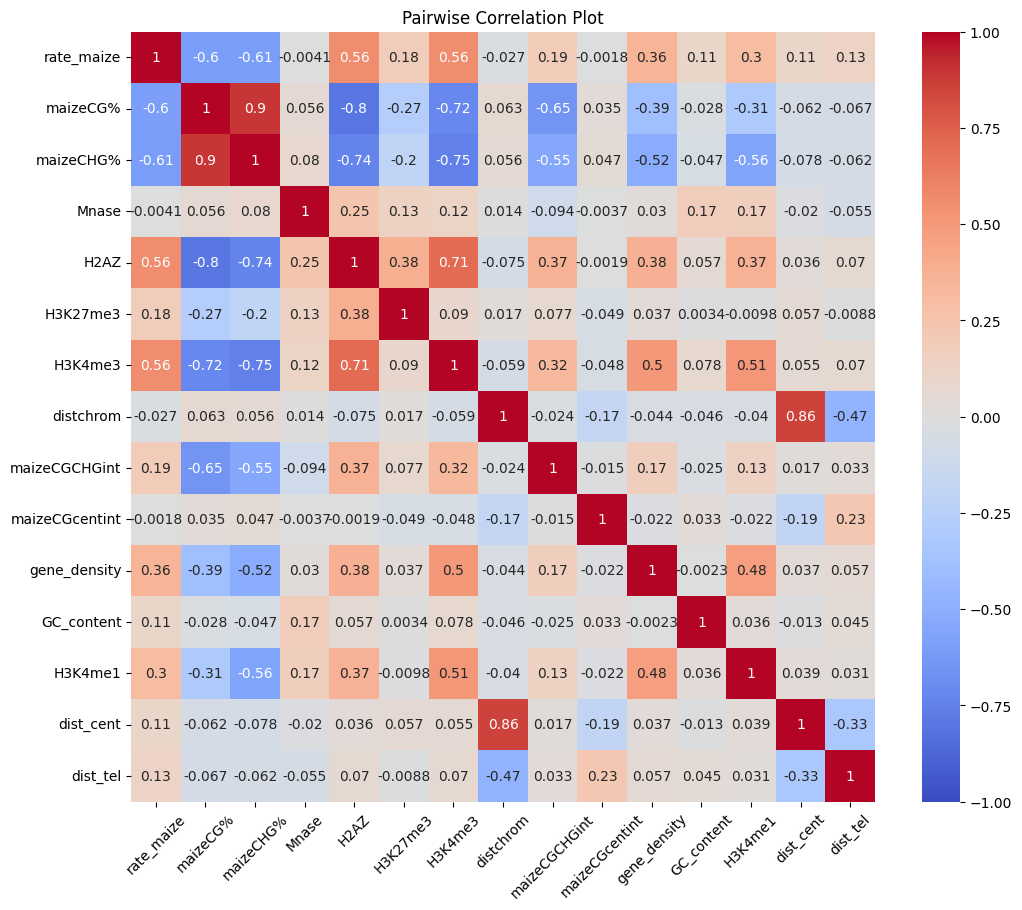

In [187]:
#looking at correlation between all predictors
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Specify the columns of interest
columns_of_interest = ['rate_maize',"maizeCG%", "maizeCHG%", "Mnase", "H2AZ", "H3K27me3", "H3K4me3",
                       'distchrom', 'maizeCGCHGint', 'maizeCGcentint', 'gene_density',"GC_content", 
                       "H3K4me1", "dist_cent","dist_tel"]

# Compute the correlation matrix
correlation_matrix = df[columns_of_interest].corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)

# Title and labels
plt.title('Pairwise Correlation Plot')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Display the plot
plt.show()


                                 OLS Regression Results                                
Dep. Variable:             rate_maize   R-squared (uncentered):                   0.706
Model:                            OLS   Adj. R-squared (uncentered):              0.705
Method:                 Least Squares   F-statistic:                              797.3
Date:                Wed, 31 Jul 2024   Prob (F-statistic):                        0.00
Time:                        13:53:12   Log-Likelihood:                         -158.17
No. Observations:                1663   AIC:                                      326.3
Df Residuals:                    1658   BIC:                                      353.4
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/home/rke27/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


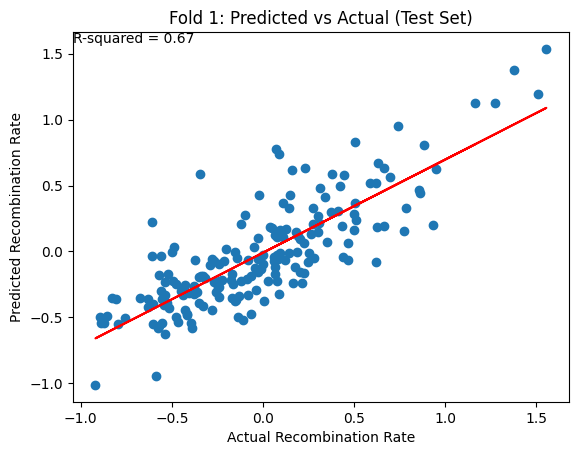

                                 OLS Regression Results                                
Dep. Variable:             rate_maize   R-squared (uncentered):                   0.699
Model:                            OLS   Adj. R-squared (uncentered):              0.698
Method:                 Least Squares   F-statistic:                              769.6
Date:                Wed, 31 Jul 2024   Prob (F-statistic):                        0.00
Time:                        13:53:12   Log-Likelihood:                         -182.81
No. Observations:                1663   AIC:                                      375.6
Df Residuals:                    1658   BIC:                                      402.7
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/home/rke27/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


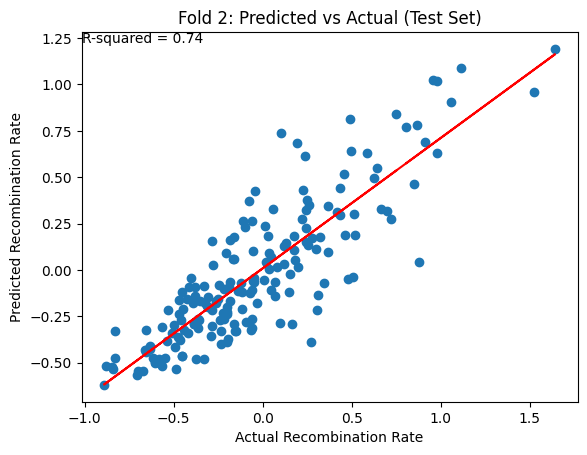

                                 OLS Regression Results                                
Dep. Variable:             rate_maize   R-squared (uncentered):                   0.705
Model:                            OLS   Adj. R-squared (uncentered):              0.704
Method:                 Least Squares   F-statistic:                              791.0
Date:                Wed, 31 Jul 2024   Prob (F-statistic):                        0.00
Time:                        13:53:13   Log-Likelihood:                         -165.71
No. Observations:                1663   AIC:                                      341.4
Df Residuals:                    1658   BIC:                                      368.5
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/home/rke27/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


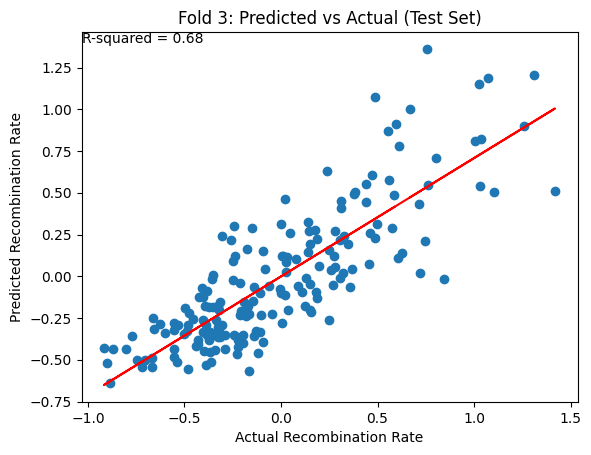

                                 OLS Regression Results                                
Dep. Variable:             rate_maize   R-squared (uncentered):                   0.705
Model:                            OLS   Adj. R-squared (uncentered):              0.704
Method:                 Least Squares   F-statistic:                              792.0
Date:                Wed, 31 Jul 2024   Prob (F-statistic):                        0.00
Time:                        13:53:13   Log-Likelihood:                         -152.27
No. Observations:                1663   AIC:                                      314.5
Df Residuals:                    1658   BIC:                                      341.6
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/home/rke27/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


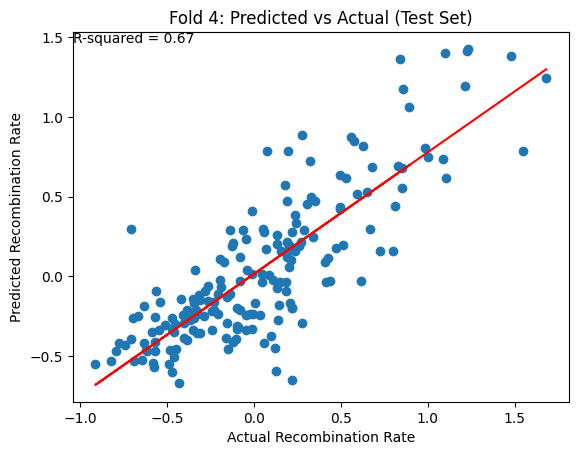

                                 OLS Regression Results                                
Dep. Variable:             rate_maize   R-squared (uncentered):                   0.697
Model:                            OLS   Adj. R-squared (uncentered):              0.696
Method:                 Least Squares   F-statistic:                              761.8
Date:                Wed, 31 Jul 2024   Prob (F-statistic):                        0.00
Time:                        13:53:13   Log-Likelihood:                         -189.61
No. Observations:                1663   AIC:                                      389.2
Df Residuals:                    1658   BIC:                                      416.3
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/home/rke27/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


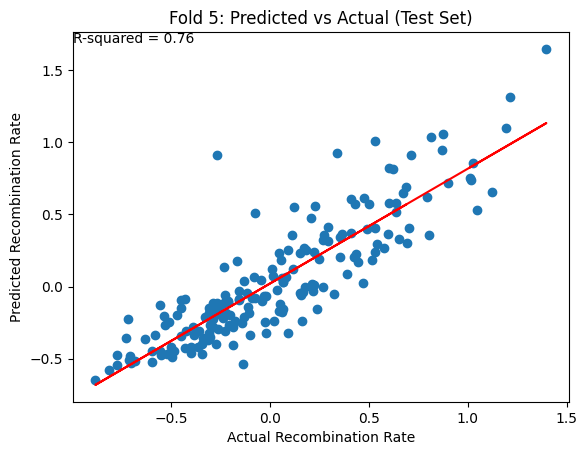

                                 OLS Regression Results                                
Dep. Variable:             rate_maize   R-squared (uncentered):                   0.699
Model:                            OLS   Adj. R-squared (uncentered):              0.698
Method:                 Least Squares   F-statistic:                              771.4
Date:                Wed, 31 Jul 2024   Prob (F-statistic):                        0.00
Time:                        13:53:13   Log-Likelihood:                         -175.03
No. Observations:                1663   AIC:                                      360.1
Df Residuals:                    1658   BIC:                                      387.1
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/home/rke27/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


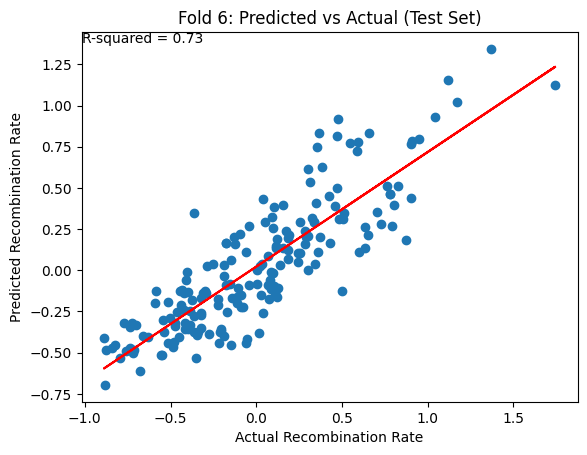

                                 OLS Regression Results                                
Dep. Variable:             rate_maize   R-squared (uncentered):                   0.696
Model:                            OLS   Adj. R-squared (uncentered):              0.695
Method:                 Least Squares   F-statistic:                              760.4
Date:                Wed, 31 Jul 2024   Prob (F-statistic):                        0.00
Time:                        13:53:14   Log-Likelihood:                         -164.08
No. Observations:                1663   AIC:                                      338.2
Df Residuals:                    1658   BIC:                                      365.2
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/home/rke27/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


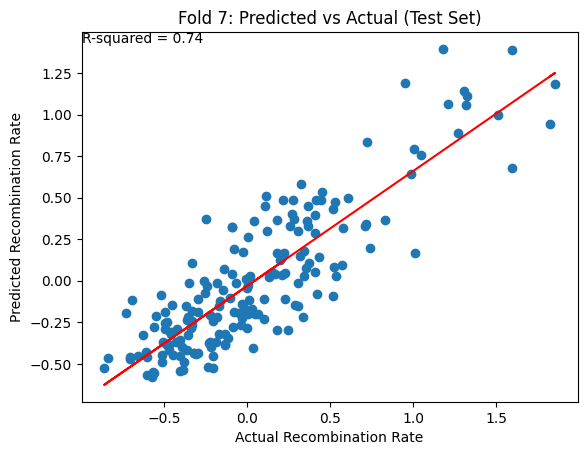

                                 OLS Regression Results                                
Dep. Variable:             rate_maize   R-squared (uncentered):                   0.700
Model:                            OLS   Adj. R-squared (uncentered):              0.699
Method:                 Least Squares   F-statistic:                              773.7
Date:                Wed, 31 Jul 2024   Prob (F-statistic):                        0.00
Time:                        13:53:14   Log-Likelihood:                         -177.03
No. Observations:                1663   AIC:                                      364.1
Df Residuals:                    1658   BIC:                                      391.1
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/home/rke27/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


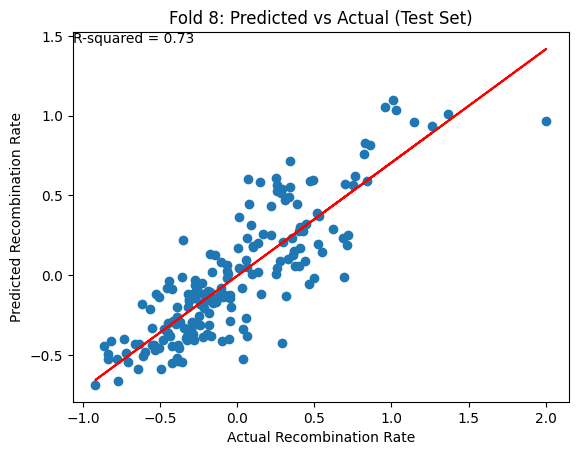

                                 OLS Regression Results                                
Dep. Variable:             rate_maize   R-squared (uncentered):                   0.705
Model:                            OLS   Adj. R-squared (uncentered):              0.704
Method:                 Least Squares   F-statistic:                              791.7
Date:                Wed, 31 Jul 2024   Prob (F-statistic):                        0.00
Time:                        13:53:14   Log-Likelihood:                         -161.11
No. Observations:                1664   AIC:                                      332.2
Df Residuals:                    1659   BIC:                                      359.3
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/home/rke27/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


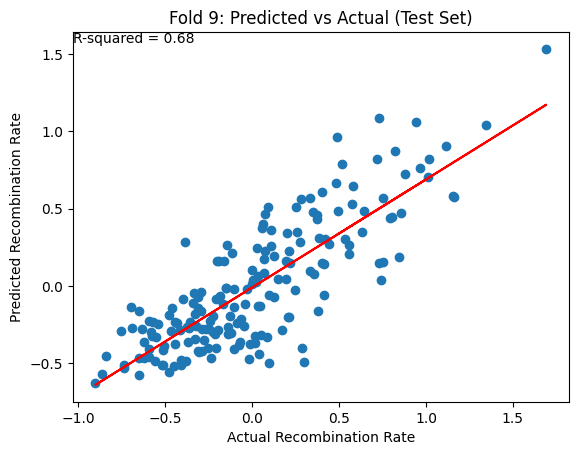

                                 OLS Regression Results                                
Dep. Variable:             rate_maize   R-squared (uncentered):                   0.709
Model:                            OLS   Adj. R-squared (uncentered):              0.708
Method:                 Least Squares   F-statistic:                              806.7
Date:                Wed, 31 Jul 2024   Prob (F-statistic):                        0.00
Time:                        13:53:14   Log-Likelihood:                         -140.16
No. Observations:                1664   AIC:                                      290.3
Df Residuals:                    1659   BIC:                                      317.4
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/home/rke27/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


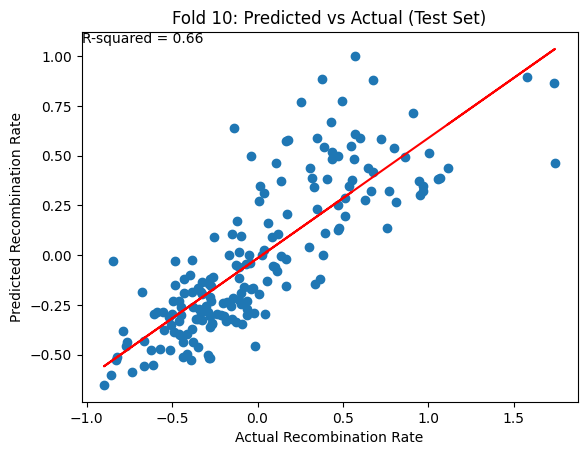

Mean R-squared: 0.70 ± 0.03
Mean RMSE: 0.265342832 ± 0.021102314


In [198]:
#training maize full model
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold
import numpy as np

# Assuming you have your data in df
columns_of_interest = ['maizeCG%','Mnase','H3K27me3','GC_content','dist_cent']
X = df[columns_of_interest].copy()
y = df['rate_maize'].copy()

# Initialize KFold with 10 splits
kf = KFold(n_splits=10, shuffle=True, random_state=10)

# Lists to store metrics
r2_scores = []
rmse_scores = []

# Perform 10-fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the model on the training set
    model = sm.OLS(y_train, exog=X_train)
    
    res=model.fit_regularized(alpha=0.005, L1_wt=1)

    model_fit_regularized = model.fit(cov_type = "HC0",params=res.params) 
    pinv_wexog,_ = pinv_extended(model.wexog)
    normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))
    summary = sm.regression.linear_model.OLSResults(model,res.params,normalized_cov_params)
    print(summary.summary())
    
    # Make predictions on the test set
    predictions = model_fit_regularized.predict(X_test)
    
    # Calculate R-squared and RMSE
    r2 = r2_score(y_test, predictions)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    
    r2_scores.append(r2)
    rmse_scores.append(rmse)

    # Plotting for each fold (optional, you might want to plot only the final model)
    plt.scatter(y_test, predictions)
    plt.xlabel("Actual Recombination Rate")
    plt.ylabel("Predicted Recombination Rate")
    plt.title(f"Fold {len(r2_scores)}: Predicted vs Actual (Test Set)")

    # Add trendline
    z = np.polyfit(y_test, predictions, 1)
    p = np.poly1d(z)
    plt.plot(y_test, p(y_test), color='red')
    
    # Add R-squared value to plot
    plt.text(plt.xlim()[0], plt.ylim()[1], f'R-squared = {r2:.2f}', horizontalalignment='left', verticalalignment='top')
    plt.show()

# Calculate mean and standard deviation of R-squared and RMSE
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)
mean_rmse = np.mean(rmse_scores)
std_rmse = np.std(rmse_scores)

print(f"Mean R-squared: {mean_r2:.2f} ± {std_r2:.2f}")
print(f"Mean RMSE: {mean_rmse:.9f} ± {std_rmse:.9f}")

In [202]:
#printing just full model trained on entire maize dataset
model = sm.OLS(df['rate_maize'], exog=df[['maizeCG%']])
res=model.fit_regularized(alpha=0.005, L1_wt=1)
model_fit_regularized = model.fit(cov_type = "HC0",params=res.params) 
pinv_wexog,_ = pinv_extended(model.wexog)
normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))
summary = sm.regression.linear_model.OLSResults(model,res.params,normalized_cov_params)
print(summary.summary())

                                 OLS Regression Results                                
Dep. Variable:             rate_maize   R-squared (uncentered):                   0.697
Model:                            OLS   Adj. R-squared (uncentered):              0.697
Method:                 Least Squares   F-statistic:                              4242.
Date:                Wed, 31 Jul 2024   Prob (F-statistic):                        0.00
Time:                        14:06:26   Log-Likelihood:                         -201.71
No. Observations:                1848   AIC:                                      405.4
Df Residuals:                    1847   BIC:                                      410.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

                                 OLS Regression Results                                
Dep. Variable:               rate_teo   R-squared (uncentered):                   0.652
Model:                            OLS   Adj. R-squared (uncentered):              0.652
Method:                 Least Squares   F-statistic:                              1557.
Date:                Wed, 31 Jul 2024   Prob (F-statistic):                        0.00
Time:                        13:22:13   Log-Likelihood:                         -105.99
No. Observations:                1663   AIC:                                      216.0
Df Residuals:                    1661   BIC:                                      226.8
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/home/rke27/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


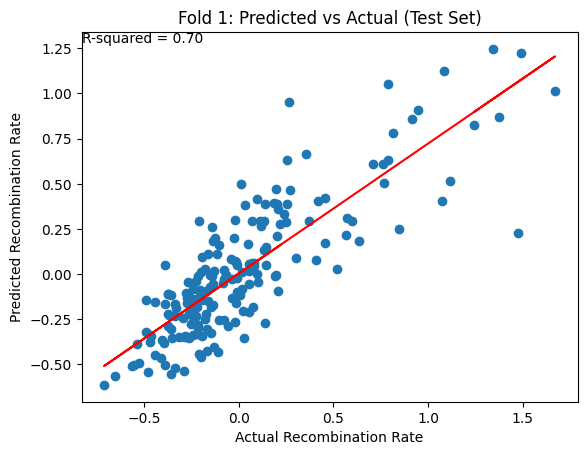

                                 OLS Regression Results                                
Dep. Variable:               rate_teo   R-squared (uncentered):                   0.654
Model:                            OLS   Adj. R-squared (uncentered):              0.654
Method:                 Least Squares   F-statistic:                              1570.
Date:                Wed, 31 Jul 2024   Prob (F-statistic):                        0.00
Time:                        13:22:14   Log-Likelihood:                         -90.282
No. Observations:                1663   AIC:                                      184.6
Df Residuals:                    1661   BIC:                                      195.4
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/home/rke27/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


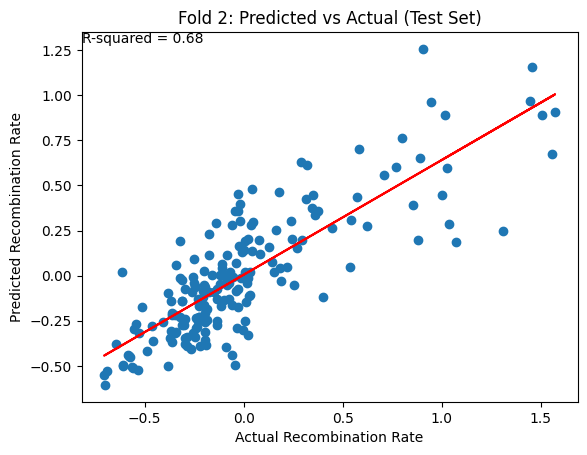

                                 OLS Regression Results                                
Dep. Variable:               rate_teo   R-squared (uncentered):                   0.651
Model:                            OLS   Adj. R-squared (uncentered):              0.651
Method:                 Least Squares   F-statistic:                              1552.
Date:                Wed, 31 Jul 2024   Prob (F-statistic):                        0.00
Time:                        13:22:14   Log-Likelihood:                         -100.68
No. Observations:                1663   AIC:                                      205.4
Df Residuals:                    1661   BIC:                                      216.2
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/home/rke27/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


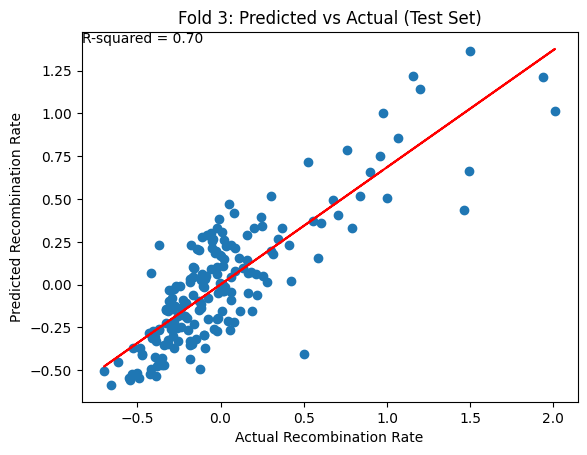

                                 OLS Regression Results                                
Dep. Variable:               rate_teo   R-squared (uncentered):                   0.658
Model:                            OLS   Adj. R-squared (uncentered):              0.657
Method:                 Least Squares   F-statistic:                              1597.
Date:                Wed, 31 Jul 2024   Prob (F-statistic):                        0.00
Time:                        13:22:14   Log-Likelihood:                         -112.37
No. Observations:                1663   AIC:                                      228.7
Df Residuals:                    1661   BIC:                                      239.6
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/home/rke27/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


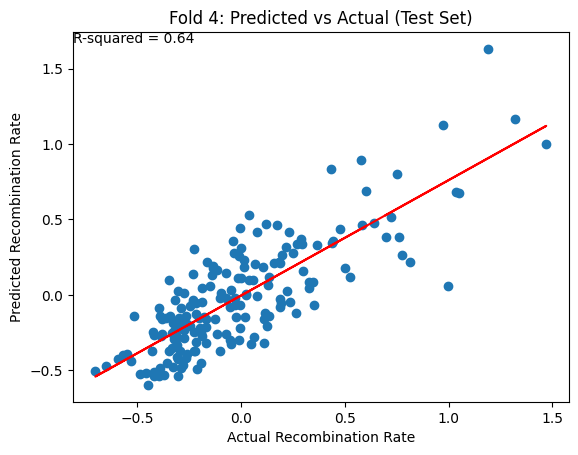

                                 OLS Regression Results                                
Dep. Variable:               rate_teo   R-squared (uncentered):                   0.661
Model:                            OLS   Adj. R-squared (uncentered):              0.661
Method:                 Least Squares   F-statistic:                              1619.
Date:                Wed, 31 Jul 2024   Prob (F-statistic):                        0.00
Time:                        13:22:14   Log-Likelihood:                         -98.877
No. Observations:                1663   AIC:                                      201.8
Df Residuals:                    1661   BIC:                                      212.6
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/home/rke27/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


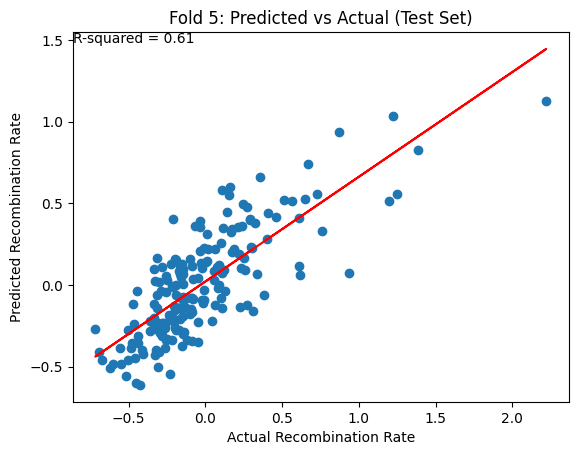

                                 OLS Regression Results                                
Dep. Variable:               rate_teo   R-squared (uncentered):                   0.653
Model:                            OLS   Adj. R-squared (uncentered):              0.652
Method:                 Least Squares   F-statistic:                              1562.
Date:                Wed, 31 Jul 2024   Prob (F-statistic):                        0.00
Time:                        13:22:15   Log-Likelihood:                         -66.838
No. Observations:                1663   AIC:                                      137.7
Df Residuals:                    1661   BIC:                                      148.5
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/home/rke27/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


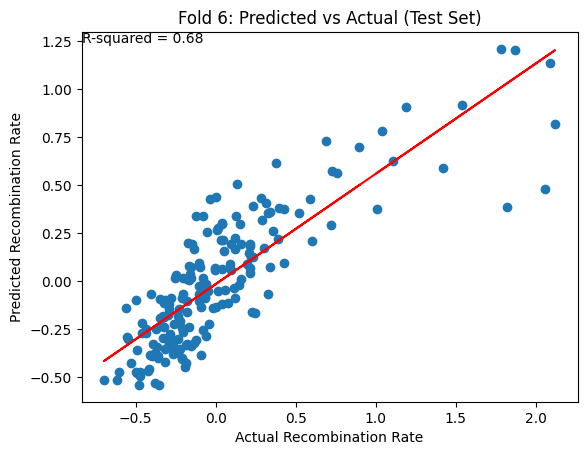

                                 OLS Regression Results                                
Dep. Variable:               rate_teo   R-squared (uncentered):                   0.662
Model:                            OLS   Adj. R-squared (uncentered):              0.662
Method:                 Least Squares   F-statistic:                              1630.
Date:                Wed, 31 Jul 2024   Prob (F-statistic):                        0.00
Time:                        13:22:15   Log-Likelihood:                         -104.95
No. Observations:                1663   AIC:                                      213.9
Df Residuals:                    1661   BIC:                                      224.7
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/home/rke27/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


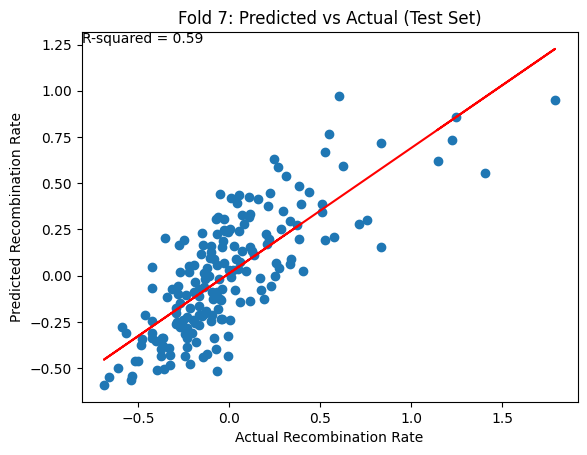

                                 OLS Regression Results                                
Dep. Variable:               rate_teo   R-squared (uncentered):                   0.660
Model:                            OLS   Adj. R-squared (uncentered):              0.659
Method:                 Least Squares   F-statistic:                              1611.
Date:                Wed, 31 Jul 2024   Prob (F-statistic):                        0.00
Time:                        13:22:15   Log-Likelihood:                         -93.400
No. Observations:                1663   AIC:                                      190.8
Df Residuals:                    1661   BIC:                                      201.6
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/home/rke27/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


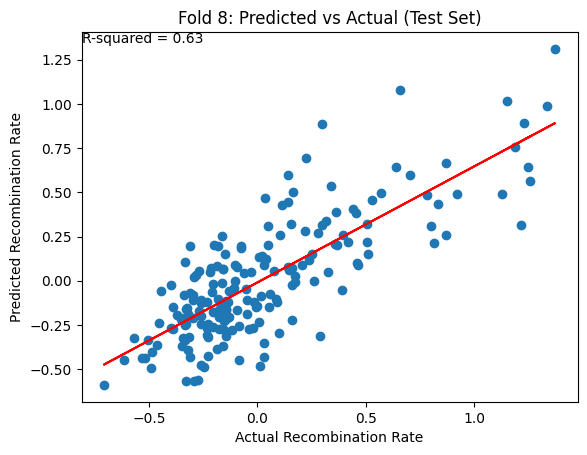

                                 OLS Regression Results                                
Dep. Variable:               rate_teo   R-squared (uncentered):                   0.657
Model:                            OLS   Adj. R-squared (uncentered):              0.657
Method:                 Least Squares   F-statistic:                              1591.
Date:                Wed, 31 Jul 2024   Prob (F-statistic):                        0.00
Time:                        13:22:15   Log-Likelihood:                         -83.202
No. Observations:                1664   AIC:                                      170.4
Df Residuals:                    1662   BIC:                                      181.2
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/home/rke27/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


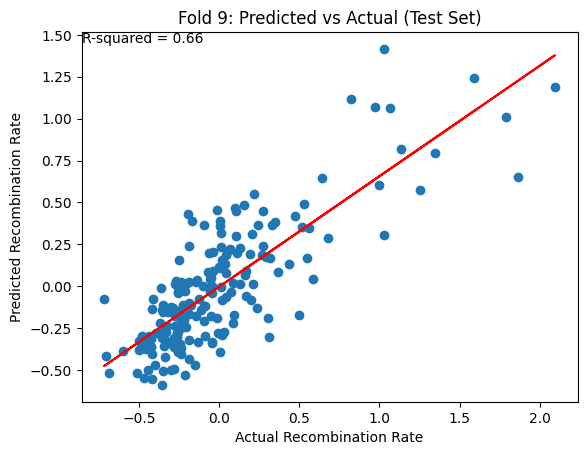

                                 OLS Regression Results                                
Dep. Variable:               rate_teo   R-squared (uncentered):                   0.657
Model:                            OLS   Adj. R-squared (uncentered):              0.657
Method:                 Least Squares   F-statistic:                              1593.
Date:                Wed, 31 Jul 2024   Prob (F-statistic):                        0.00
Time:                        13:22:16   Log-Likelihood:                         -87.756
No. Observations:                1664   AIC:                                      179.5
Df Residuals:                    1662   BIC:                                      190.3
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/home/rke27/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


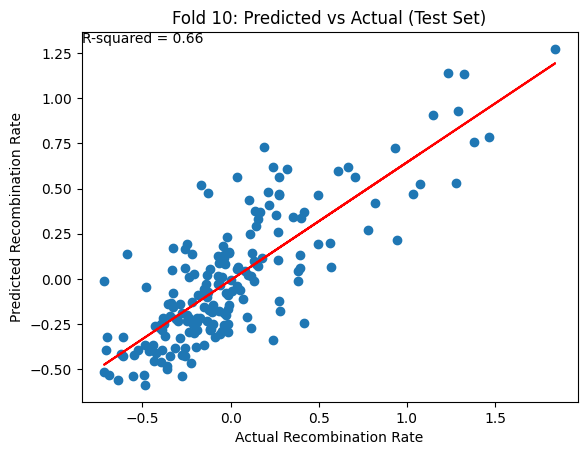

Mean R-squared: 0.65 ± 0.04
Mean RMSE: 0.254551099 ± 0.017378704


In [166]:
#training full model in teosinte

# Assuming you have your data in df
columns_of_interest =  ["teoCHG%"]
X = df[columns_of_interest].copy()
y = df['rate_teo'].copy()

# Initialize KFold with 10 splits
kf = KFold(n_splits=10, shuffle=True, random_state=1)

# Lists to store metrics
r2_scores = []
rmse_scores = []

# Perform 10-fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the model on the training set
    model = sm.OLS(y_train, exog=X_train)
    
    res=model.fit_regularized(alpha=0.05, L1_wt=1)

    model_fit_regularized = model.fit(cov_type = "HC0",params=res.params) 
    pinv_wexog,_ = pinv_extended(model.wexog)
    normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))
    summary = sm.regression.linear_model.OLSResults(model,res.params,normalized_cov_params)
    print(summary.summary())

    # Make predictions on the test set
    predictions = model_fit_regularized.predict(X_test)
    
    # Calculate R-squared and RMSE
    r2 = r2_score(y_test, predictions)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    
    r2_scores.append(r2)
    rmse_scores.append(rmse)

    # Plotting for each fold (optional, you might want to plot only the final model)
    plt.scatter(y_test, predictions)
    plt.xlabel("Actual Recombination Rate")
    plt.ylabel("Predicted Recombination Rate")
    plt.title(f"Fold {len(r2_scores)}: Predicted vs Actual (Test Set)")

    # Add trendline
    z = np.polyfit(y_test, predictions, 1)
    p = np.poly1d(z)
    plt.plot(y_test, p(y_test), color='red')
    
    # Add R-squared value to plot
    plt.text(plt.xlim()[0], plt.ylim()[1], f'R-squared = {r2:.2f}', horizontalalignment='left', verticalalignment='top')
    plt.show()

# Calculate mean and standard deviation of R-squared and RMSE
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)
mean_rmse = np.mean(rmse_scores)
std_rmse = np.std(rmse_scores)

print(f"Mean R-squared: {mean_r2:.2f} ± {std_r2:.2f}")
print(f"Mean RMSE: {mean_rmse:.9f} ± {std_rmse:.9f}")

In [331]:
# calculate VIF for all the variables to detect for multicollinearity
vif = pd.DataFrame()
vif["features"] = X.columns
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

,features,VIF Factor
0,chrom,5.297840
1,teoCG%,36.064192
2,Mnase,2.700685
3,teoCHG%,52.917047
4,H2AZ,12.715072
5,gene_density,2.954501
6,H3K27me3,1.496906
7,H3K4me3,8.797929
8,H3K4me1,38.702372
9,GC_content,1.463951


In [201]:
#printing out teosinte full model
model = sm.OLS(df['rate_teo'], exog=df[['teoCHG%']])
res=model.fit_regularized(alpha=0.005, L1_wt=1)
model_fit_regularized = model.fit(cov_type = "HC0",params=res.params) 
pinv_wexog,_ = pinv_extended(model.wexog)
normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))
summary = sm.regression.linear_model.OLSResults(model,res.params,normalized_cov_params)
print(summary.summary())

                                 OLS Regression Results                                
Dep. Variable:               rate_teo   R-squared (uncentered):                   0.655
Model:                            OLS   Adj. R-squared (uncentered):              0.655
Method:                 Least Squares   F-statistic:                              3502.
Date:                Wed, 31 Jul 2024   Prob (F-statistic):                        0.00
Time:                        14:01:20   Log-Likelihood:                         -110.18
No. Observations:                1848   AIC:                                      222.4
Df Residuals:                    1847   BIC:                                      227.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

                                 OLS Regression Results                                
Dep. Variable:               rate_teo   R-squared (uncentered):                   0.625
Model:                            OLS   Adj. R-squared (uncentered):              0.623
Method:                 Least Squares   F-statistic:                              281.7
Date:                Tue, 30 Jul 2024   Prob (F-statistic):                   2.76e-302
Time:                        15:32:40   Log-Likelihood:                          810.50
No. Observations:                1663   AIC:                                     -1605.
Df Residuals:                    1655   BIC:                                     -1562.
Df Model:                           8                                                  
Covariance Type:                  HC0                                                  
                   coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------

/home/rke27/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


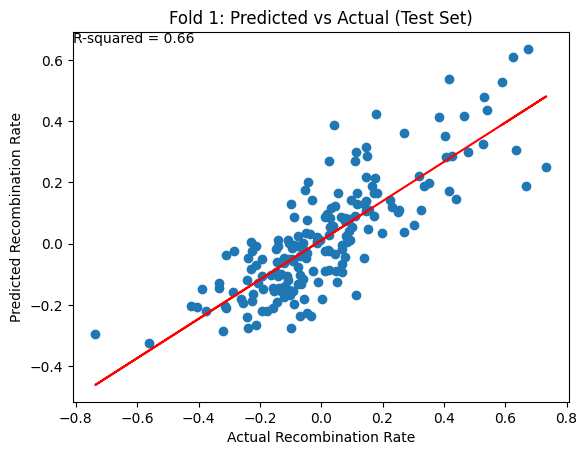

                                 OLS Regression Results                                
Dep. Variable:               rate_teo   R-squared (uncentered):                   0.621
Model:                            OLS   Adj. R-squared (uncentered):              0.620
Method:                 Least Squares   F-statistic:                              275.7
Date:                Tue, 30 Jul 2024   Prob (F-statistic):                   6.58e-298
Time:                        15:32:40   Log-Likelihood:                          821.41
No. Observations:                1663   AIC:                                     -1627.
Df Residuals:                    1655   BIC:                                     -1583.
Df Model:                           8                                                  
Covariance Type:                  HC0                                                  
                   coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------

/home/rke27/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


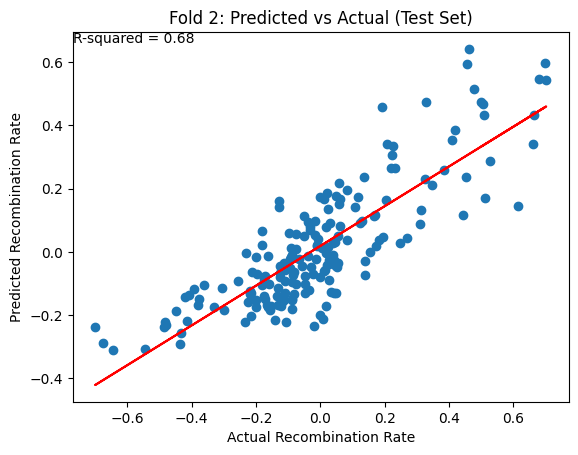

                                 OLS Regression Results                                
Dep. Variable:               rate_teo   R-squared (uncentered):                   0.626
Model:                            OLS   Adj. R-squared (uncentered):              0.624
Method:                 Least Squares   F-statistic:                              284.0
Date:                Tue, 30 Jul 2024   Prob (F-statistic):                   5.55e-304
Time:                        15:32:40   Log-Likelihood:                          816.46
No. Observations:                1663   AIC:                                     -1617.
Df Residuals:                    1655   BIC:                                     -1574.
Df Model:                           8                                                  
Covariance Type:                  HC0                                                  
                   coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------

/home/rke27/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


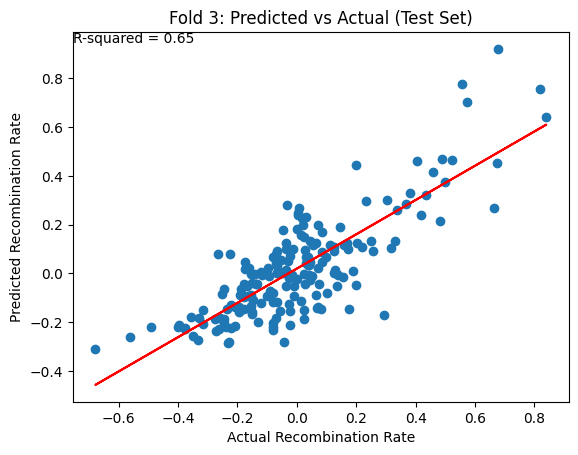

                                 OLS Regression Results                                
Dep. Variable:               rate_teo   R-squared (uncentered):                   0.631
Model:                            OLS   Adj. R-squared (uncentered):              0.629
Method:                 Least Squares   F-statistic:                              284.1
Date:                Tue, 30 Jul 2024   Prob (F-statistic):                   4.35e-304
Time:                        15:32:40   Log-Likelihood:                          810.69
No. Observations:                1663   AIC:                                     -1605.
Df Residuals:                    1655   BIC:                                     -1562.
Df Model:                           8                                                  
Covariance Type:                  HC0                                                  
                   coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------

/home/rke27/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


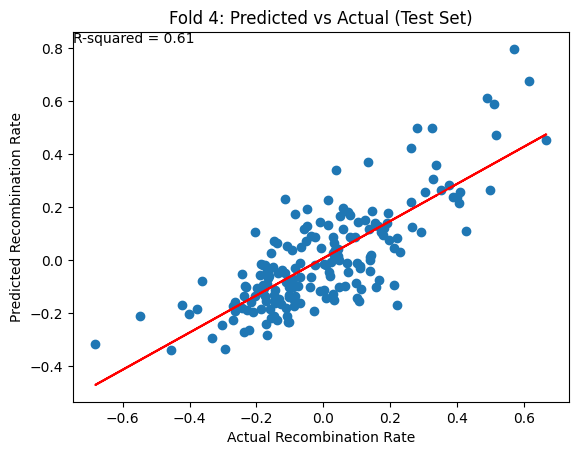

                                 OLS Regression Results                                
Dep. Variable:               rate_teo   R-squared (uncentered):                   0.633
Model:                            OLS   Adj. R-squared (uncentered):              0.632
Method:                 Least Squares   F-statistic:                              297.4
Date:                Tue, 30 Jul 2024   Prob (F-statistic):                   1.26e-313
Time:                        15:32:40   Log-Likelihood:                          823.91
No. Observations:                1663   AIC:                                     -1632.
Df Residuals:                    1655   BIC:                                     -1588.
Df Model:                           8                                                  
Covariance Type:                  HC0                                                  
                   coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------

/home/rke27/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


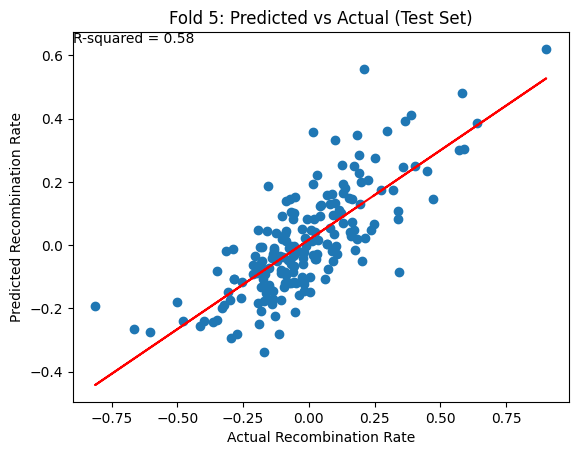

                                 OLS Regression Results                                
Dep. Variable:               rate_teo   R-squared (uncentered):                   0.623
Model:                            OLS   Adj. R-squared (uncentered):              0.622
Method:                 Least Squares   F-statistic:                              287.7
Date:                Tue, 30 Jul 2024   Prob (F-statistic):                   1.07e-306
Time:                        15:32:41   Log-Likelihood:                          827.10
No. Observations:                1663   AIC:                                     -1638.
Df Residuals:                    1655   BIC:                                     -1595.
Df Model:                           8                                                  
Covariance Type:                  HC0                                                  
                   coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------

/home/rke27/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


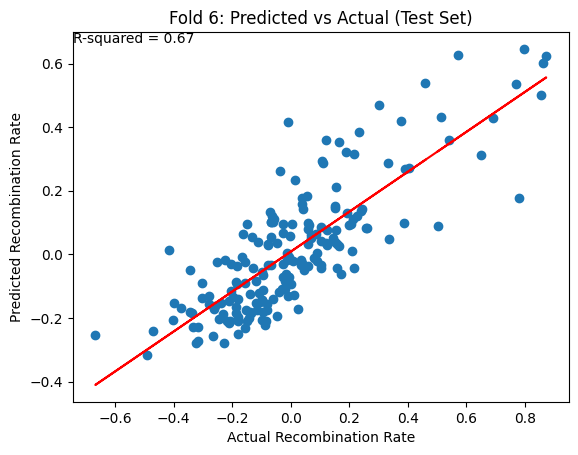

                                 OLS Regression Results                                
Dep. Variable:               rate_teo   R-squared (uncentered):                   0.629
Model:                            OLS   Adj. R-squared (uncentered):              0.627
Method:                 Least Squares   F-statistic:                              284.5
Date:                Tue, 30 Jul 2024   Prob (F-statistic):                   2.26e-304
Time:                        15:32:41   Log-Likelihood:                          802.69
No. Observations:                1663   AIC:                                     -1589.
Df Residuals:                    1655   BIC:                                     -1546.
Df Model:                           8                                                  
Covariance Type:                  HC0                                                  
                   coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------

/home/rke27/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


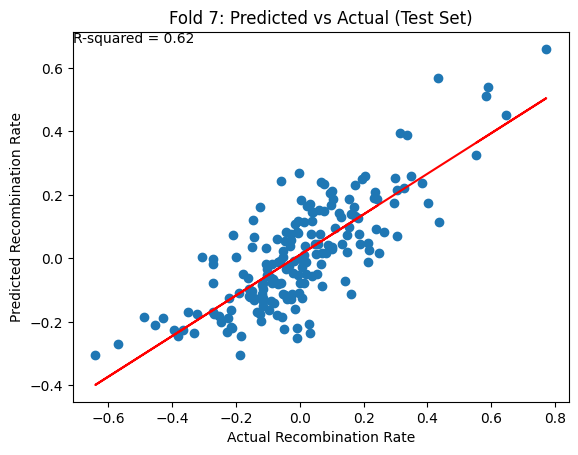

                                 OLS Regression Results                                
Dep. Variable:               rate_teo   R-squared (uncentered):                   0.636
Model:                            OLS   Adj. R-squared (uncentered):              0.635
Method:                 Least Squares   F-statistic:                              295.4
Date:                Tue, 30 Jul 2024   Prob (F-statistic):                   2.97e-312
Time:                        15:32:41   Log-Likelihood:                          832.16
No. Observations:                1663   AIC:                                     -1648.
Df Residuals:                    1655   BIC:                                     -1605.
Df Model:                           8                                                  
Covariance Type:                  HC0                                                  
                   coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------

/home/rke27/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


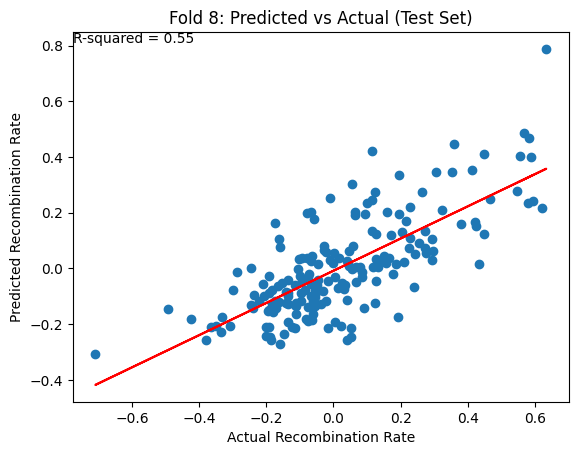

                                 OLS Regression Results                                
Dep. Variable:               rate_teo   R-squared (uncentered):                   0.626
Model:                            OLS   Adj. R-squared (uncentered):              0.624
Method:                 Least Squares   F-statistic:                              280.9
Date:                Tue, 30 Jul 2024   Prob (F-statistic):                   8.20e-302
Time:                        15:32:41   Log-Likelihood:                          822.58
No. Observations:                1664   AIC:                                     -1629.
Df Residuals:                    1656   BIC:                                     -1586.
Df Model:                           8                                                  
Covariance Type:                  HC0                                                  
                   coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------

/home/rke27/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


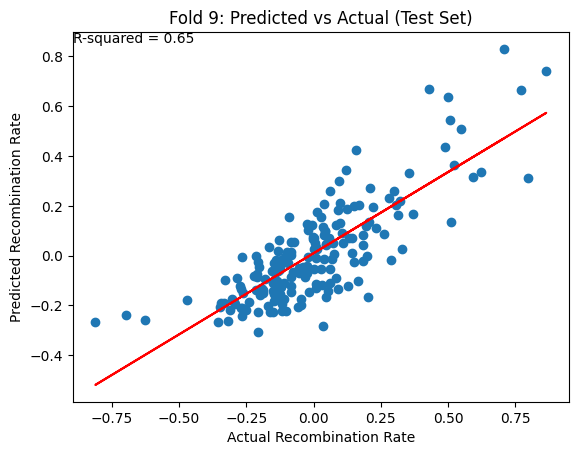

                                 OLS Regression Results                                
Dep. Variable:               rate_teo   R-squared (uncentered):                   0.639
Model:                            OLS   Adj. R-squared (uncentered):              0.638
Method:                 Least Squares   F-statistic:                              282.4
Date:                Tue, 30 Jul 2024   Prob (F-statistic):                   7.45e-303
Time:                        15:32:42   Log-Likelihood:                          866.57
No. Observations:                1664   AIC:                                     -1717.
Df Residuals:                    1656   BIC:                                     -1674.
Df Model:                           8                                                  
Covariance Type:                  HC0                                                  
                   coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------

/home/rke27/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


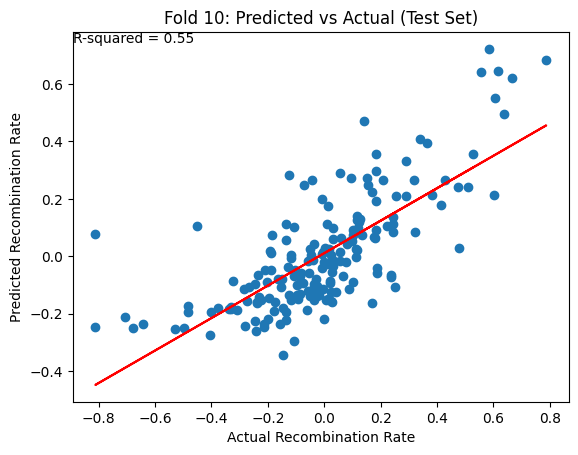

Mean R-squared: 0.62 ± 0.05
Mean RMSE: 0.147755540 ± 0.012475024


In [465]:
#training simplified model in teosinte
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold
import numpy as np

# Assuming you have your data in df
columns_of_interest = ['chrom','Mnase',"gene_density", "H3K27me3", "H3K4me3", 'teoCGCHGint', 'teoCGcentint','distchrom']
X = df_3[columns_of_interest].copy()
y = df_3['rate_teo'].copy()

# Initialize KFold with 10 splits
kf = KFold(n_splits=10, shuffle=True, random_state=1)

# Lists to store metrics
r2_scores = []
rmse_scores = []

# Perform 10-fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the model on the training set
    model = sm.OLS(y_train, exog=X_train).fit(cov_type = "HC0")
    # Make predictions on the test set
    predictions = model.predict(X_test)
    print(model.summary())
    # Calculate R-squared and RMSE
    r2 = r2_score(y_test, predictions)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    
    r2_scores.append(r2)
    rmse_scores.append(rmse)

    # Plotting for each fold (optional, you might want to plot only the final model)
    plt.scatter(y_test, predictions)
    plt.xlabel("Actual Recombination Rate")
    plt.ylabel("Predicted Recombination Rate")
    plt.title(f"Fold {len(r2_scores)}: Predicted vs Actual (Test Set)")

    # Add trendline
    z = np.polyfit(y_test, predictions, 1)
    p = np.poly1d(z)
    plt.plot(y_test, p(y_test), color='red')
    
    # Add R-squared value to plot
    plt.text(plt.xlim()[0], plt.ylim()[1], f'R-squared = {r2:.2f}', horizontalalignment='left', verticalalignment='top')
    plt.show()

# Calculate mean and standard deviation of R-squared and RMSE
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)
mean_rmse = np.mean(rmse_scores)
std_rmse = np.std(rmse_scores)

print(f"Mean R-squared: {mean_r2:.2f} ± {std_r2:.2f}")
print(f"Mean RMSE: {mean_rmse:.9f} ± {std_rmse:.9f}")

In [466]:
#teosinte reduced model on entire teosinte dataset
model = sm.OLS(df_3['rate_teo'], exog=df_3[['chrom','Mnase',"gene_density", "H3K27me3", "H3K4me3",'teoCGCHGint', 'teoCGcentint','distchrom']]).fit(cov_type = "HC0")
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:               rate_teo   R-squared (uncentered):                   0.629
Model:                            OLS   Adj. R-squared (uncentered):              0.627
Method:                 Least Squares   F-statistic:                              316.0
Date:                Tue, 30 Jul 2024   Prob (F-statistic):                        0.00
Time:                        15:32:48   Log-Likelihood:                          914.24
No. Observations:                1848   AIC:                                     -1812.
Df Residuals:                    1840   BIC:                                     -1768.
Df Model:                           8                                                  
Covariance Type:                  HC0                                                  
                   coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------

                                 OLS Regression Results                                
Dep. Variable:             rate_maize   R-squared (uncentered):                   0.697
Model:                            OLS   Adj. R-squared (uncentered):              0.697
Method:                 Least Squares   F-statistic:                              3483.
Date:                Wed, 31 Jul 2024   Prob (F-statistic):                        0.00
Time:                        13:27:33   Log-Likelihood:                         -201.69
No. Observations:                1848   AIC:                                      405.4
Df Residuals:                    1847   BIC:                                      410.9
Df Model:                           1                                                  
Covariance Type:                  HC0                                                  
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

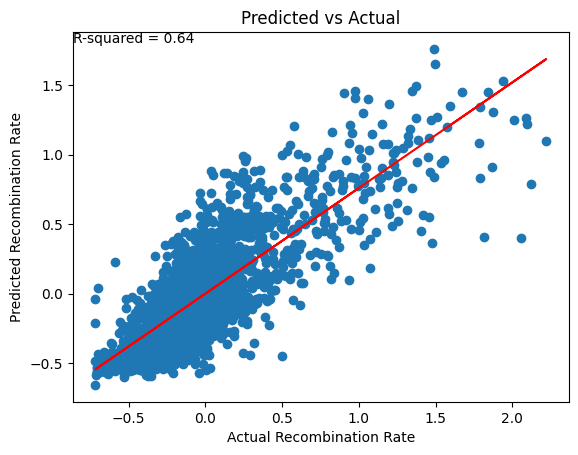

In [169]:
#using simplified maize model to predict teosinte recombination rates
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

columns_of_interest = ['maizeCG%']
X_train = df[columns_of_interest].copy()
y_train = df['rate_maize'].copy()

X_test = df[columns_of_interest].copy()
y_test = df['rate_teo'].copy()

# Fit the model on the training set
model = sm.OLS(y_train, exog=X_train).fit(cov_type = "HC0")
print(model.summary())

# Make predictions on the test set
predictions = model.predict(X_test)

# Calculate R-squared and RMSE
r2 = r2_score(y_test, predictions)
rmse = mean_squared_error(y_test, predictions)

# Print the metrics
print(f"R-squared: {r2:.2f}")
print(f"RMSE: {rmse:.9f}")

# Plotting the results
plt.scatter(y_test, predictions)
plt.xlabel("Actual Recombination Rate")
plt.ylabel("Predicted Recombination Rate")
plt.title("Predicted vs Actual")

# Add trendline
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), color='red')

# Add R-squared value to plot
plt.text(plt.xlim()[0], plt.ylim()[1], f'R-squared = {r2:.2f}', horizontalalignment='left', verticalalignment='top')
plt.savefig("Maize_prediction_inteosinte.pdf", format="pdf", bbox_inches='tight')
plt.show()

                                 OLS Regression Results                                
Dep. Variable:               rate_teo   R-squared (uncentered):                   0.636
Model:                            OLS   Adj. R-squared (uncentered):              0.635
Method:                 Least Squares   F-statistic:                              1828.
Date:                Wed, 31 Jul 2024   Prob (F-statistic):                   2.84e-278
Time:                        13:31:29   Log-Likelihood:                         -159.96
No. Observations:                1848   AIC:                                      321.9
Df Residuals:                    1847   BIC:                                      327.4
Df Model:                           1                                                  
Covariance Type:                  HC0                                                  
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

/home/rke27/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


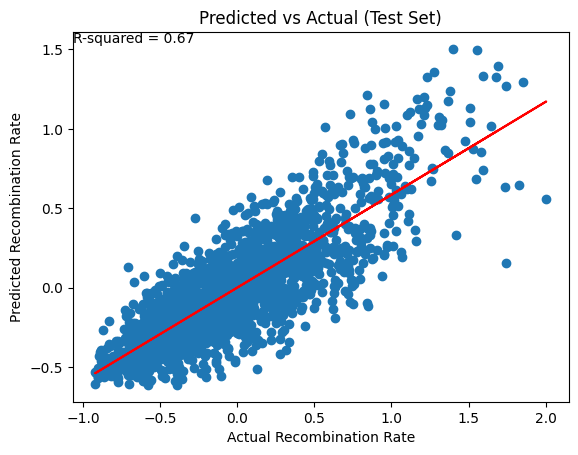

In [171]:
#using simplified teosinte model to predict maize recombination rates
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

columns_of_interest = ['teoCG%']
X_train = df[columns_of_interest].copy()
y_train = df['rate_teo'].copy()

X_test = df[columns_of_interest].copy()
y_test = df['rate_maize'].copy()

# Fit the model on the training set
model = sm.OLS(y_train, exog=X_train).fit(cov_type = "HC0")
print(model.summary())
# Make predictions on the test set
predictions = model.predict(X_test)

# Calculate R-squared and RMSE
r2 = r2_score(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)

# Print the metrics
print(f"R-squared: {r2:.2f}")
print(f"RMSE: {rmse:.9f}")

# Plotting the results
plt.scatter(y_test, predictions)
plt.xlabel("Actual Recombination Rate")
plt.ylabel("Predicted Recombination Rate")
plt.title("Predicted vs Actual (Test Set)")

# Add trendline
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), color='red')

# Add R-squared value to plot
plt.text(plt.xlim()[0], plt.ylim()[1], f'R-squared = {r2:.2f}', horizontalalignment='left', verticalalignment='top')
plt.savefig("Teosinte_prediction_inmaize.pdf", format="pdf", bbox_inches='tight')
plt.show()

(array([ 9.,  0.,  8.,  0., 14., 12., 17.,  6.,  5., 20., 20., 24., 23.,
        30., 26., 38., 39., 24., 48., 37., 43., 41., 25., 40., 33., 25.,
        26., 22.,  8., 17., 17.,  9.,  4.,  3.,  7.,  2.,  2.,  0.,  0.,
         1.]),
 array([0.99355576, 1.03455148, 1.07554719, 1.11654291, 1.15753862,
        1.19853433, 1.23953005, 1.28052576, 1.32152148, 1.36251719,
        1.4035129 , 1.44450862, 1.48550433, 1.52650005, 1.56749576,
        1.60849148, 1.64948719, 1.6904829 , 1.73147862, 1.77247433,
        1.81347005, 1.85446576, 1.89546147, 1.93645719, 1.9774529 ,
        2.01844862, 2.05944433, 2.10044004, 2.14143576, 2.18243147,
        2.22342719, 2.2644229 , 2.30541861, 2.34641433, 2.38741004,
        2.42840576, 2.46940147, 2.51039718, 2.5513929 , 2.59238861,
        2.63338433]),
 <BarContainer object of 40 artists>)

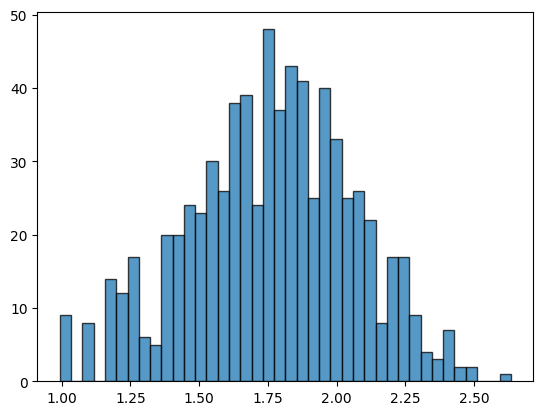

In [214]:
#seeing if recombination rates and gene density are both normally distributed with transformation
import math
plt.hist(df['gene_density']**0.15, bins=40, alpha=0.75, edgecolor='black')

(array([ 25.,  21.,  47.,  71., 115., 179., 198., 207., 151., 178., 120.,
         98.,  77.,  69.,  48.,  32.,  25.,  25.,  15.,  13.,  21.,  14.,
          9.,  16.,   9.,   9.,  13.,   6.,   7.,   7.,   6.,   2.,   1.,
          0.,   5.,   2.,   1.,   2.,   3.,   1.]),
 array([-0.71750517, -0.64404373, -0.5705823 , -0.49712086, -0.42365943,
        -0.35019799, -0.27673656, -0.20327512, -0.12981369, -0.05635225,
         0.01710918,  0.09057062,  0.16403205,  0.23749349,  0.31095492,
         0.38441636,  0.45787779,  0.53133923,  0.60480066,  0.6782621 ,
         0.75172353,  0.82518497,  0.8986464 ,  0.97210784,  1.04556927,
         1.11903071,  1.19249214,  1.26595358,  1.33941501,  1.41287645,
         1.48633788,  1.55979932,  1.63326075,  1.70672219,  1.78018362,
         1.85364506,  1.92710649,  2.00056793,  2.07402936,  2.1474908 ,
         2.22095223]),
 <BarContainer object of 40 artists>)

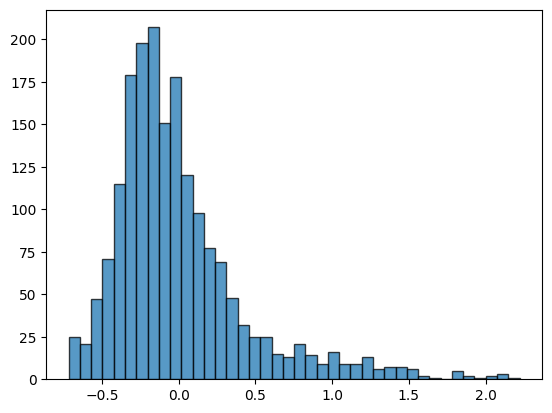

In [212]:
plt.hist(df['rate_teo'], bins=40, alpha=0.75, edgecolor='black')

In [218]:
#correlating teosinte recombination landscape to maize recombination landscape with transformation & without
(df['rate_maize']).corr(df['rate_teo'], method = 'pearson')

0.8518481998328634

In [215]:
#correlating maize recombination landscape to gene density
(df['rate_maize']).corr(df['gene_density'], method = 'spearman')

0.6606146916716474

In [216]:
#correlating teosinte recombination landscape to gene density
(df['rate_teo']).corr(df['gene_density'], method = 'spearman')

0.646041201661042